# Evoluční algoritmy - Genetické programování

Dneska se podíváme na jednoduché genetické programování. Vyzkoušíme si ho na problému symbolické regrese, kdy bude naším cílem nalézt vzoreček, který bude nejlépe odpovídat zadaným datům, a klasifikace, kdy budeme hledat rozhodovací strom pomocí genetického programování.

K tomuto budeme používat knihovnu deap, kterou jsme si ukázali minule.

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image

import operator
from deap import gp
from deap import creator, base, tools, algorithms

import pydot
from IPython.display import Image

Nejprve si vygenerujeme data v nějakém rozumném rozsahu a k nim odpovídající labely, například pomocí funkce sinus. Pro ně pak budeme chtít najít vzoreček regrese, který jim bude nejlépe odpovídat.

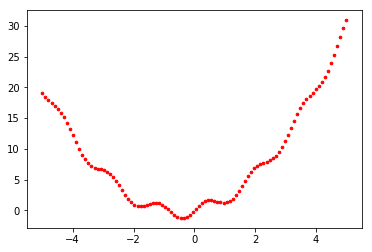

In [14]:
x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.scatter(x_train, y_train,s=7,c='r')
plt.show()

Pro práci s genetickým algoritmem budeme potřebovat vyvořit množinu terminálů a neterminálů, se kterými bude evoluce pracovat. K tomu v knihovně deap existuje třída `gp.PrimitiveSet`, případně `gp.PrimitiveSetTyped` pro typované GP. V našem příkladu použijeme tu typovanou verzi, protože je obecnější. Jelikož ale budeme používat jen jeden typ, šla by použít i netypovaná verze. Jako terminály si definujeme konstanty 0,1,2, zbytek se dovytvoří z nich. Jako neterminály budeme potřebovat operace sčítání, násobení a sinus, a protože zbylé operace se ve vzorečku nevyskytují, nebudeme si jimi zbytečně komplikovat život.

In [27]:
# mnozina se jmenuje MAIN, vstup je jeden float, vystup je taky jeden float
pset = gp.PrimitiveSetTyped('MAIN', [float], float) 

# terminaly
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)


# neterminaly
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
#pset.addPrimitive(operator.sub, [float, float], float)
#pset.addPrimitive(np.cos, [float], float)
#pset.addPrimitive(operator.truediv, [float, float], float)

Když máme vytvořené terminály a neterminály, můžeme si definovat jedince, fitness funkci a genetické operátory. Fitness funkce bude MSE (Mean Squared Error), která počítá střední hodnoty druhých mocnin rozdílů mezi predikovanou výstupní hodnotou a skutečnou výstupní hodnotou.

In [28]:
# definujeme fitness 
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # vytvorime funkci podle jedince
    vals = list(map(func, x)) # zavolame funkci na data
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind) #spocitame chybu pomoci MSE

# vytvorime tridy pro jedince
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# nastavime algoritmus
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) 

# limity na hloubku stromu
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

C:\Users\katie\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\katie\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Nyní jsme si napsali všechny potřebné operátory a definovali jsme si populaci, tak si ještě dodefinujeme nějaké statistické metody, abychom mohli sledovat vývoj evoluce a pak můžeme náš algoritmus pro GP pustit.

In [29]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg   	gen	max	min	nevals	std    
0  	1000  	398.269	0  	61623.9	16.0404	1000  	2903.51	64.399	0  	901	4  	1000  	105.393
1  	500   	137.69 	1  	29837.5	16.0404	500   	939.871	44.697	1  	901	2  	500   	84.9662
2  	587   	101.552	2  	3091.7 	7.03293	587   	104.475	34.242	2  	782	2  	587   	58.8364
3  	538   	90.102 	3  	2198.89	7.03293	538   	92.0784	30.894	3  	394	3  	538   	40.8962
4  	578   	88.7155	4  	3239.21	7.03293	578   	193.18 	33.37 	4  	393	2  	578   	40.3622
5  	540   	10799  	5  	1.07178e+07	7.03293	540   	338756 	34.636	5  	393	3  	540   	35.6545
6  	530   	55.4842	6  	2793.03    	7.03293	530   	144.019	40.648	6  	393	3  	530   	40.5269
7  	543   	46.7385	7  	1623.9     	7.03293	543   	92.0066	54.1  	7  	394	3

80 	543   	28.3811	80 	798.381    	0          	543   	65.3967    	14.709 	80 	44 	3  	543   	3.74864
81 	515   	36.627 	81 	4445.45    	0          	515   	159.104    	14.745 	81 	44 	5  	515   	3.67124
82 	504   	27.9686	82 	499.931    	0          	504   	71.1242    	14.399 	82 	36 	2  	504   	3.45453
83 	553   	30.3589	83 	866.212    	0          	553   	73.2943    	14.366 	83 	31 	3  	553   	3.13784
84 	552   	30.3862	84 	1626.11    	0          	552   	86.0224    	14.45  	84 	32 	2  	552   	3.2978 
85 	539   	26.7726	85 	500.201    	0          	539   	64.4421    	14.472 	85 	31 	4  	539   	3.10825
86 	533   	34.876 	86 	552.599    	0          	533   	82.9873    	14.425 	86 	32 	2  	533   	3.28335
87 	559   	32.8651	87 	499.953    	0          	559   	79.599     	14.481 	87 	37 	3  	559   	3.46289
88 	528   	31.8524	88 	1765.84    	0          	528   	91.2498    	14.454 	88 	29 	3  	528   	3.11928
89 	526   	30.8987	89 	980.153    	0          	526   	75.7126    	14.553 	89 	33 	3  	526  

Vidíme, že výstup výše je sice krásný a dostatečně vypovídající, ale asi bychom víc ocenili nějakou vizualici. Proto si napíšeme pomocnou funkci na zobrazení vytvořeného stromu. To uděláme pomocí knihovny *pydot*, která slouží právě ke zobrazování grafů.

In [30]:
# zobrazeni jedince jako stromu
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

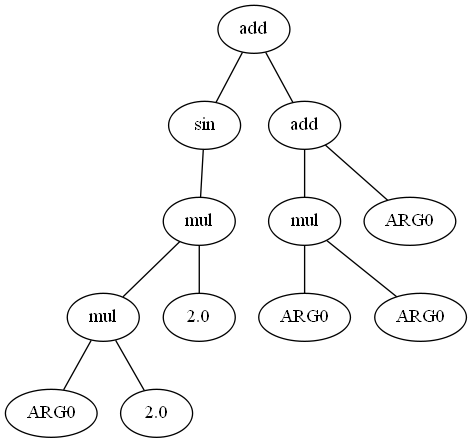

In [31]:
Image(plot_tree(hof[0]))

Ještě si napíšeme jednoduchou funkci, která nám vykreslí graf, abychom se mohli podívat, jak vypadá naše naučená funkce vzhledem k datům.

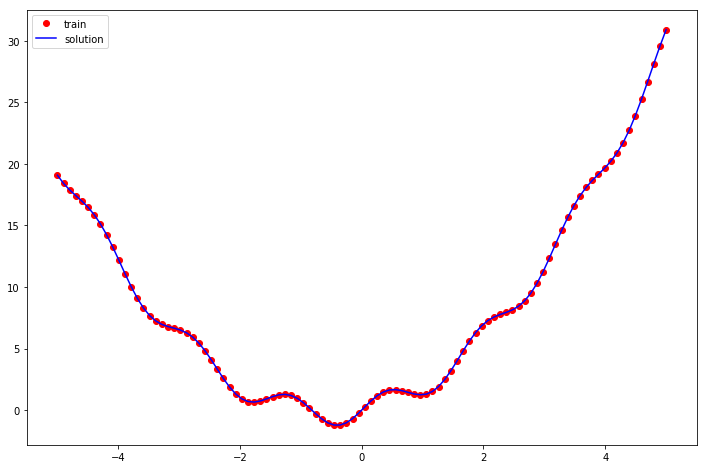

In [32]:
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'ro', label='train')
plt.plot(x_train, y, 'b',label='solution')
plt.legend()
plt.show()

## Úkol na cvičení

Zkuste pomocí genetického programování řešit problém klasifikace, např. pro dataset Iris, se kterým jsme pracovali na prvním cvičení. Promyslete si, jak definovat množinu primitiv a fitness. Následně je naimplementujte je a pusťte genetické programování.